In [26]:
!pip install matplotlib
!pip install pandas


[notice] A new release of pip is available: 23.3.1 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 40.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 509.2/509.2 kB 96.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.8/347.8 kB 80.1 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.3.1 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip


In [31]:
import json
import re

def validate_structure(parsed_json):
    # Deve essere una lista
    if not isinstance(parsed_json, list):
        return False
    # Deve contenere esattamente 3 elementi
    if len(parsed_json) != 3:
        return False
    for item in parsed_json:
        if not isinstance(item, dict):
            return False
        # Devono esserci tutte e sole queste chiavi
        required_keys = {"model_name", "confidence", "explanation"}
        if set(item.keys()) != required_keys:
            return False
        # Tipi di dato
        if not isinstance(item["model_name"], str):
            return False
        if not isinstance(item["confidence"], (int, float)):
            return False
        if not 0 <= item["confidence"] <= 1:
            return False
        if not isinstance(item["explanation"], str):
            return False
    return True

In [32]:
# Cartella contenente i JSON
folder_path = "/workspace/gerlando/TestCCO/results"

# Carica tutti i JSON in un dizionario
data_dict = {}
for file_name in os.listdir(folder_path):
    if file_name.endswith(".json"):
        key = file_name.replace(".json", "")
        file_path = os.path.join(folder_path, file_name)
        with open(file_path, "r") as f:
            data_dict[key] = json.load(f)

# Dizionario finale per tutti i risultati processati
parsed_data_dict = {}
total_invalid_count = 0

# Cicla su ogni JSON caricato
for key, data in data_dict.items():
    count = 0
    parsed_query = []

    for element in data:
        # 1. Estrarre "user prompt"
        match_user_prompt = re.search(
            r"User prompt:\n(.+?)(?:\n\nSTRICT OUTPUT RULES:)",
            element["prompt"],
            re.DOTALL
        )
        user_prompt = match_user_prompt.group(1).strip() if match_user_prompt else None

        # 2. Estrarre "task type"
        match_task = re.search(r"Task type:\s*(.+)", element["prompt"])
        task_type = match_task.group(1).strip() if match_task else None

        # 3. Estrarre JSON da "generated_text" DOPO </think>
        text_after_think = element["generated_text"][0].split("</think>", 1)[-1].strip()
        match_json = re.search(r"(\[.*\]|\{.*\})", text_after_think, re.DOTALL)
        if match_json:
            json_str = match_json.group(1).strip()
            try:
                parsed_json = json.loads(json_str)
                if validate_structure(parsed_json):
                    parsed_query.append({
                        "user_query": user_prompt,
                        "model_output": parsed_json
                    })
                else:
                    count += 1
            except json.JSONDecodeError:
                count += 1
        else:
            count += 1

    parsed_data_dict[key] = parsed_query
    total_invalid_count += count

print("Numero JSON invalidi totali:", total_invalid_count)
print("Chiavi elaborate:", parsed_data_dict.keys())


Numero JSON invalidi totali: 134
Chiavi elaborate: dict_keys(['<image_depth>', '<image_denoise>', '<image_deblur>', '<image_canny>', '<controllable_video_generation>', '<controllable_image_generation>'])


In [ ]:
import random
olympus_instruct = []
for q in parsed_query:
	best_model = max(q['model_output'], key=lambda x: x['confidence'])
	
	# worst_model = min(q['model_name'], key=lambda x: x['confidence'])

	# if abs(best_model['confidence'] - worst_model['confidence']) < 0.15:
	# 	q['model_name'] = random.choice(q['model_name'])['model_name']
	# else:
	# 	q['model_name'] = best_model['model_name'] 
	

# Create model list for APIBench and MLLM

In [35]:
import py7zr
import json
import os
import tempfile

model_info_map = {}  # key = model_name, value = complete JSON object

with tempfile.TemporaryDirectory() as temp_dir, py7zr.SevenZipFile('/workspace/gerlando/cleaned_mllm.7z', 'r') as archive:
    archive.extractall(path=temp_dir)

    for root, _, files in os.walk(temp_dir):
        for file in filter(lambda f: f.endswith('.json'), files):
            file_path = os.path.join(root, file)
            with open(file_path, 'r', encoding='utf-8') as f:
                for line in f:
                    line = line.strip()
                    if line:
                        try:
                            obj = json.loads(line)
                            # use model_name as the key to ensure unique objects
                            if "model_name" in obj:
                                model_info_map[obj["model_name"]] = obj
                        except json.JSONDecodeError:
                            pass  # ignore invalid lines

# All unique JSON objects
mllm_models = model_info_map
print(f"Number of unique models for MLLM: {len(mllm_models.keys())}")


with open("/workspace/gerlando/cleaned_apibench_train.json", "r") as f:
    apibench = [json.loads(line) for line in f]

apibench_models = {}
for item in apibench:
    apibench_models[item["model_name"]] = item  # l'ultimo overwrite i precedenti
print(len(apibench_models.keys()))

Number of unique models for MLLM: 860
919


In [29]:
# import pandas as pd

# # Carica tutto il file come DataFrame
# df = pd.read_json("/workspace/gerlando/cleaned_apibench_train.json", lines=True)

# print("Number of unique models:", df["model_name"].nunique())
# print("DataFrame shape:", df.shape)
# print("Example rows:")
# print(df.head())


In [47]:
import json
# parsed_query = parsed_data_dict['<controllable_image_generation>']
# Carica il primo dataset (con tutte le informazioni)


# Estendiamo dataset2
extended_dataset = []
count = 0
for tag in parsed_data_dict:
    for q in parsed_data_dict[tag]:
        model_name = max(q['model_output'], key=lambda x: x['confidence'])['model_name']
        if model_name in apibench_models:
            model_info = apibench_models[model_name]
        elif model_name in mllm_models:
            model_info = mllm_models[model_name]
        else:
            model_info = None
            count = count + 1
        new_item = {
                "instruction": q['user_query'],
                "model_name": model_info["model_name"] if model_info else model_name,
                "created_at": model_info["created_at"] if model_info else "NEW",
                "domain": model_info.get("domain", "N/A") if model_info else "NEW",
                "original_dataset": model_info.get("original_dataset", "N/A") if model_info else "NEW",
                "model_source": model_info.get("model_source", "N/A") if model_info else "NEW",
                "api_data": model_info.get("api_data", {}) if model_info else "NEW"
        }
        extended_dataset.append(new_item)
    # show histogram

# Salviamo il risultato
# with open("extended_dataset.json", "w") as f:
#     for item in extended_dataset:
#         f.write(json.dumps(item) + "\n")

# print("Dataset esteso correttamente, duplicati gestiti!")
# extended_dataset
print('Query resolved with models > 8/2024 // Query resolved with models < 8/2024', count/len(extended_dataset)*100)

Query resolved with models > 8/2024 // Query resolved with models < 8/2024 11.890003381043615


In [51]:
extended_dataset[1000]

{'instruction': 'Can you minimize the graininess in this snapshot?',
 'model_name': 'lllyasviel/sd-controlnet-canny',
 'created_at': 1677221723000,
 'domain': 'Computer Vision Image-to-Image',
 'original_dataset': 'APIBench',
 'model_source': 'HuggingFace',
 'api_data': '{\'domain\': \'Computer Vision Image-to-Image\', \'framework\': \'Hugging Face\', \'functionality\': \'Image-to-Image\', \'api_name\': \'lllyasviel/sd-controlnet-canny\', \'api_call\': "ControlNetModel.from_pretrained(\'lllyasviel/sd-controlnet-canny\')", \'performance\': {\'dataset\': \'3M edge-image, caption pairs\', \'accuracy\': \'600 GPU-hours with Nvidia A100 80G\'}, \'description\': \'ControlNet is a neural network structure to control diffusion models by adding extra conditions. This checkpoint corresponds to the ControlNet conditioned on Canny edges. It can be used in combination with Stable Diffusion.\'}'}

In [ ]:
for i, q in enumerate(parsed_query):
    if not isinstance(q['model_name'], str):
        print(f"[{i}] model_name = {q['model_name']} (tipo: {type(q['model_name'])})")


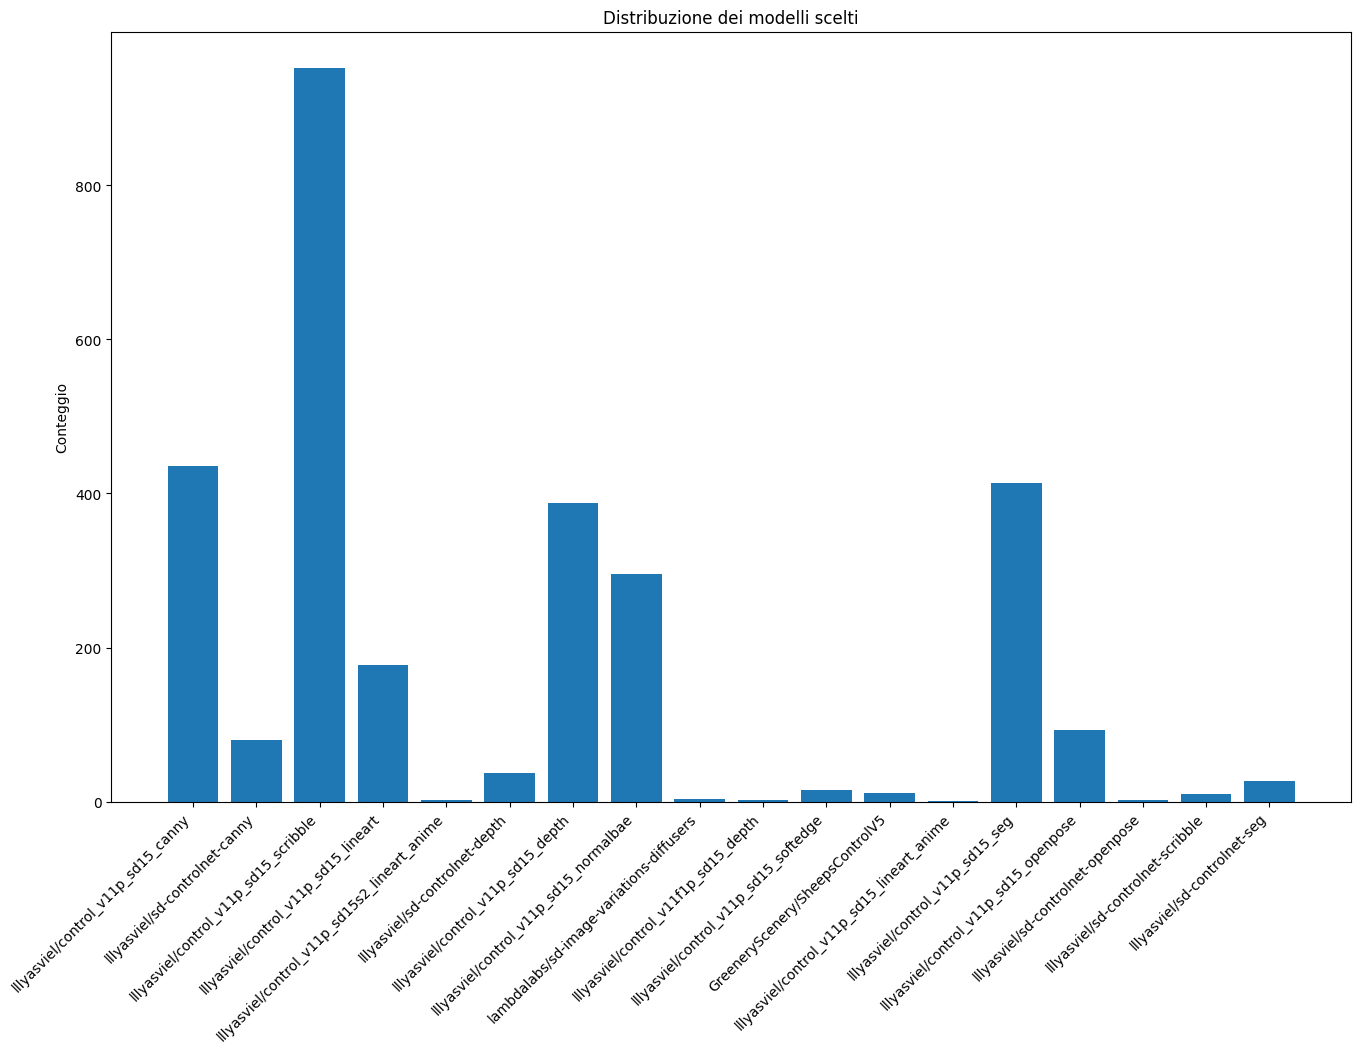

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt
model_names = [q['model_name'] for q in parsed_query]
counts = Counter(model_names)

# Plot
a = plt.figure(figsize=(16, 10))
a = plt.bar(counts.keys(), counts.values())
a = plt.xticks(rotation=45, ha='right')
a = plt.ylabel("Conteggio")
a = plt.title("Distribuzione dei modelli scelti")
plt.show()